In [60]:
%load_ext autoreload
%autoreload 2

In [11]:
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
import h5py
from dvidutils import LabelMapper
from DVIDSparkServices.io_util.labelmap_utils import compare_mappings, mapping_from_edges

In [30]:
!pwd

/nrs/flyem/bergs/final-agglo-fixsplit


In [31]:
#ls

### Already-reviewed bodies

In [81]:
path = 'all_completed_0.2_hb_bodies.csv'
reviewed_bodies = pd.read_csv(path, header=None, names=['old_body', 'user', 'assignment_id'])['old_body']

### Supervoxel sizes

In [13]:
sizes_file = '/groups/flyem/data/scratchspace/copyseg-configs/labelmaps/hemibrain/8nm/compute-8nm-extended-fixed-STATS-ONLY-20180402.192015/supervoxel-sizes.h5'
with h5py.File(sizes_file, 'r') as f:
    sv_sizes = pd.Series(index=f['sv_ids'][:], data=f['sv_sizes'][:])
sv_sizes.name = 'voxel_count'
sv_sizes.index.name = 'sv'
print(f"Volume contains {len(sv_sizes)} supervoxels and {sv_sizes.values.sum()/1e12:.1f} Teravoxels in total")

Volume contains 188243164 supervoxels and 22.5 Teravoxels in total


### Load Old Mapping

In [14]:
# We start with the EXACT mapping that FlyEM has been using, even though it includes "phantom" supervoxels.
old_mapping_csv = '../final-agglo/LABEL-TO-BODY-final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all.csv'
old_mapping_df = pd.read_csv(old_mapping_csv, header=None, names=['sv', 'body'], dtype=np.uint64)
old_mapper = LabelMapper(old_mapping_df['sv'].values, old_mapping_df['body'].values)

# This analysis can't use a 'minimal' mapping;
# identity-mapped rows are not implicit, except for bodies with only one supervoxel.
old_mapping_min_svs = old_mapping_df.groupby('body').min()
assert (old_mapping_min_svs['sv'] == old_mapping_min_svs.index).all()

### Old body sizes

In [15]:
# Calculate sizes of all agglomerated bodies
old_mapping_with_sizes = old_mapping_df.merge(pd.DataFrame(sv_sizes), left_on=['sv'], right_index=True, copy=False)
old_body_sizes = old_mapping_with_sizes.groupby('body').agg({'voxel_count': [np.sum, 'size']})
old_body_sizes.columns = ['voxel_count', 'sv_count']

# Store SVs in a pd.Index to get hash table performance in the query below.
old_agglomerated_svs = pd.Index(old_mapping_df['sv'])

# Append sizes of unagglomerated supervoxels
old_unagglomerated_sizes = pd.DataFrame(sv_sizes, columns=['voxel_count']).query('index not in @old_agglomerated_svs')
old_unagglomerated_sizes['sv_count'] = 1
old_body_sizes = pd.concat((old_body_sizes, old_unagglomerated_sizes))

old_body_sizes['voxel_count'] = old_body_sizes['voxel_count'].astype(np.uint64)
old_body_sizes['sv_count'] = old_body_sizes['sv_count'].astype(np.uint32)

# Save RAM
del old_agglomerated_svs
del old_unagglomerated_sizes

In [16]:
## We remove phantoms from the 'sv' column, but NOT the body column,
## since our production volume actually includes phantoms in the body IDs.
#phantoms = set(pd.read_csv('phantoms.csv', header=None, dtype=np.uint64, names=['sv'])['sv'])
#old_mapping_NO_PHANTOMS_df = old_mapping_df.query('sv not in @phantoms')
##old_mapping_NO_PHANTOMS_df.query('body in @phantoms')

In [17]:
#new_edges = np.array((new_merge_table['id_a'], new_merge_table['id_b'])).transpose()
#new_mapping_plain = mapping_from_edges(new_edges)
#new_mapping_plain_df = pd.DataFrame(new_mapping_plain, columns=['sv', 'body'])
#new_mapping_plain_df.to_csv('MAPPING-final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_upd0408_v2.csv', header=False, index=False)

### Load New Mapping

In [18]:
new_mapping_csv = 'MAPPING-final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_upd0408_v2.csv'

# Here, "POSTPROCESSED" means renames were applied and then remaining 'phantoms' were dropped
#new_mapping_csv = 'MAPPING-final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_upd0408_v2-POSTPROCESSED.csv'

new_mapping_df = pd.read_csv(new_mapping_csv, header=None, names=['sv', 'body'], dtype=np.uint64)
new_mapper = LabelMapper(new_mapping_df['sv'].values, new_mapping_df['body'].values)

# This analysis can't use a 'minimal' mapping;
# identity-mapped rows are not implicit, except for bodies with only one supervoxel.
new_mapping_min_svs = new_mapping_df.groupby('body').min()
assert (new_mapping_min_svs['sv'] == new_mapping_min_svs.index).all()

### New body sizes

In [19]:
new_mapping_with_sizes = new_mapping_df.merge(pd.DataFrame(sv_sizes), left_on=['sv'], right_index=True, copy=False)
new_body_sizes = new_mapping_with_sizes.groupby('body').agg({'voxel_count': [np.sum, 'size']})
new_body_sizes.columns = ['voxel_count', 'sv_count']

# Store SVs in a pd.Index to get hash table performance in the query below.
new_agglomerated_svs = pd.Index(new_mapping_df['sv'])

# Append sizes of unagglomerated supervoxels
new_unagglomerated_sizes = pd.DataFrame(sv_sizes, columns=['voxel_count']).query('index not in @new_agglomerated_svs')
new_unagglomerated_sizes['sv_count'] = np.uint32(1)
new_body_sizes = pd.concat((new_body_sizes, new_unagglomerated_sizes))

new_body_sizes['voxel_count'] = new_body_sizes['voxel_count'].astype(np.uint64)
new_body_sizes['sv_count'] = new_body_sizes['sv_count'].astype(np.uint32)

# Save RAM
del new_agglomerated_svs
del new_unagglomerated_sizes

# Merge Graph Comparisons: Splits/Merges/Both

## Detect Splits

In [23]:
old_merge_table_csv = '../final-agglo/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all.npy'
#old_merge_table_csv = '../final-agglo/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all-PHANTOMS-DROPPED.npy'

old_merge_table = np.load(old_merge_table_csv)
old_edges_df = pd.DataFrame({'id_a': old_merge_table['id_a'],
                             'id_b': old_merge_table['id_b']})

old_edges_df['old_body_a'] = old_mapper.apply(old_edges_df['id_a'].values, allow_unmapped=True)
old_edges_df['old_body_b'] = old_mapper.apply(old_edges_df['id_b'].values, allow_unmapped=True)
old_edges_df['new_body_a'] = new_mapper.apply(old_edges_df['id_a'].values, allow_unmapped=True)
old_edges_df['new_body_b'] = new_mapper.apply(old_edges_df['id_b'].values, allow_unmapped=True)

new_splits = old_edges_df.query('new_body_a != new_body_b')

assert (new_splits['old_body_a'] == new_splits['old_body_b']).all()
print(f"Detected {len(new_splits)} split edges")

split_body_pairs = new_splits[['new_body_a', 'new_body_b']].values
unique_splits = pd.DataFrame(np.sort(split_body_pairs, axis=1)).drop_duplicates()
print(f"Detected {len(unique_splits)} split pairs")

split_body_ids = pd.unique(new_splits[['new_body_a', 'new_body_b']].values.reshape(-1))
print(f"Detected {len(split_body_ids)} bodies in the new volume that are the result of splits")

Detected 1951 split edges
Detected 1397 split pairs
Detected 2273 bodies in the new volume that are the result of splits


## Detect Merges

In [24]:
new_merge_table_csv = 'final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_upd0408_v2.npy'
#new_merge_table_csv = 'final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_upd0408_v2-POSTPROCESSED.npy'

new_merge_table = np.load(new_merge_table_csv)

new_edges_df = pd.DataFrame({'id_a': new_merge_table['id_a'],
                             'id_b': new_merge_table['id_b']})
new_edges_df['old_body_a'] = old_mapper.apply(new_edges_df['id_a'].values, allow_unmapped=True)
new_edges_df['old_body_b'] = old_mapper.apply(new_edges_df['id_b'].values, allow_unmapped=True)
new_edges_df['new_body_a'] = new_mapper.apply(new_edges_df['id_a'].values, allow_unmapped=True)
new_edges_df['new_body_b'] = new_mapper.apply(new_edges_df['id_b'].values, allow_unmapped=True)

new_merges = new_edges_df.query('old_body_a != old_body_b')
assert (new_merges['new_body_a'] == new_merges['new_body_b']).all()
print(f"Detected {len(new_merges)} new merge edges")

merged_body_pairs = new_merges[['old_body_a', 'old_body_b']].values
unique_merges = pd.DataFrame(np.sort(merged_body_pairs, axis=1)).drop_duplicates()
print(f"Detected {len(unique_merges)} new body mergers")

merged_body_ids = pd.unique(new_merges['new_body_a'].values)
print(f"Detected {len(merged_body_ids)} new bodies with SV additions (mergers)")

Detected 377868 new merge edges
Detected 289407 new body mergers
Detected 46920 new bodies with SV additions (mergers)


## Break down

In [25]:
# These sets are from the NEW agglo
split_only_bodies = set(split_body_ids) - set(merged_body_ids)
merged_only_bodies = set(merged_body_ids) - set(split_body_ids)
merged_and_split_bodies = set(split_body_ids).intersection(merged_body_ids)
merged_or_split_bodies = set(split_body_ids).union(merged_body_ids)

In [26]:
change_counts = {'split only': len(split_only_bodies),
                 'merge only': len(merged_only_bodies),
                 'both': len(merged_and_split_bodies),
                 'either': len(merged_or_split_bodies)}
set_changes_df = pd.DataFrame({'num bodies': list(change_counts.values())}, index=list(change_counts.keys()))
set_changes_df

,num bodies
split only,287
merge only,44934
both,1986
either,47207


In [27]:
counts_df.loc['added'] + counts_df.loc['changed_size'] + counts_df.loc['changed_content']

num bodies    47206
dtype: int64

## Impact Analysis

### Merge-only changes

In [29]:
merged_only_stats = pd.DataFrame(index=sorted(merged_only_bodies))
merged_only_stats.index.name = 'new_body'
merged_only_stats['original_body'] = np.uint32(0)
merged_only_stats['supervoxels_added'] = np.uint32(0)
merged_only_stats['voxels_added'] = np.uint64(0)

for new_body_id in tqdm_notebook(merged_only_stats.index):
    this_body_voxels = new_body_sizes.loc[new_body_id]['voxel_count']
    this_body_svcount = new_body_sizes.loc[new_body_id]['sv_count']
    
    # Find the rows in the new merge table that involve this body
    this_body_merges = new_merges.query('new_body_a == @new_body_id')

    # Which old bodies were merged into this new body?
    component_old_bodies = pd.unique(this_body_merges[['old_body_a', 'old_body_b']].values.reshape(-1))
    
    # Which of those old bodies was the biggest?
    original_body = old_body_sizes.loc[component_old_bodies]['sv_count'].argmax()
    original_body_voxels = old_body_sizes.loc[original_body]['voxel_count']
    original_body_svcount = old_body_sizes.loc[original_body]['sv_count']
    
    merged_only_stats.loc[new_body_id, 'original_body'] = original_body
    merged_only_stats.loc[new_body_id, 'voxels_added'] = this_body_voxels - original_body_voxels
    merged_only_stats.loc[new_body_id, 'supervoxels_added'] = this_body_svcount - original_body_svcount

HBox(children=(IntProgress(value=0, max=44934), HTML(value='')))

In [50]:
merged_only_stats.sort_values(['voxels_added', 'supervoxels_added'], ascending=False, inplace=True)
merged_only_stats[:10]

,original_body,supervoxels_added,voxels_added
new_body,,,
635062078,1730647233,1567.0,3.625472e+09
1901802926,2122471230,848.0,2.029277e+09
733450505,1008663678,567.0,1.583965e+09
734214073,823913632,1047.0,1.306696e+09
235657437,235657437,912.0,1.078942e+09
1436201428,1478461516,332.0,9.878824e+08
2128566765,2128566765,435.0,8.503072e+08
264438149,264438149,507.0,8.130002e+08
1344543578,2306309799,240.0,7.971084e+08


In [59]:
len(merged_only_stats)

44934

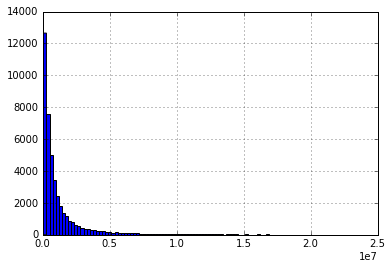

In [93]:
p = merged_only_stats['voxels_added'][1000:].hist(bins=100)
#p.set_yscale('log')
#p.set_xscale('log')
p

### Links

In [76]:
selected_ranks = [0,1]

selected_old_bodies = list(map(int, merged_only_stats['original_body'].iloc[selected_ranks]))
selected_new_bodies = list(map(int, merged_only_stats.index[selected_ranks]))

link = """https://neuroglancer-demo.appspot.com/#!
{
    "layers": {
        "raw_clahe_yz": {
            "source": "brainmaps://274750196357:hemibrain:raw_clahe_yz",
            "type": "image"
        },
        "base20180227_8nm_watershed_fixed": {
            "source": "brainmaps://274750196357:hemibrain:base20180227_8nm_watershed_fixed",
            "type": "segmentation",
            "visible": false
        },
        "ffn_agglo_20180312_32_16_8_freeze10": {
            "source": "brainmaps://274750196357:hemibrain:base20180227_8nm_watershed_fixed:ffn_agglo_20180312_32_16_8_freeze10",
            "type": "segmentation",
            "visible": false,
            "segments": OLD_BODIES
        },
        "ffn_agglo_20180312_32_16_8_freeze10_upd0408_fixsplit": {
            "source": "brainmaps://274750196357:hemibrain:base20180227_8nm_watershed_fixed:ffn_agglo_20180312_32_16_8_freeze10_upd0408_fixsplit",
            "type": "segmentation",
            "segments": NEW_BODIES
        }
    },
    "navigation": {
        "pose": {
            "position": {
                "voxelSize": [
                    8,
                    8,
                    8
                ],
                "voxelCoordinates": [
                    7893.0771484375,
                    23479.380859375,
                    12839.341796875
                ]
            }
        },
        "zoomFactor": 13.90973176638051
    },
    "perspectiveOrientation": [
        0.2490045130252838,
        0.5367637276649475,
        -0.5498400330543518,
        0.5895399451255798
    ],
    "perspectiveZoom": 59.44193775124134,
    "showSlices": false,
    "selectedLayer": {
        "layer": "ffn_agglo_20180312_32_16_8_freeze10"
    }
}""".replace('OLD_BODIES', str(selected_old_bodies)).replace('NEW_BODIES', str(selected_new_bodies))

print('')
print(link)


https://neuroglancer-demo.appspot.com/#!
{
    "layers": {
        "raw_clahe_yz": {
            "source": "brainmaps://274750196357:hemibrain:raw_clahe_yz",
            "type": "image"
        },
        "base20180227_8nm_watershed_fixed": {
            "source": "brainmaps://274750196357:hemibrain:base20180227_8nm_watershed_fixed",
            "type": "segmentation",
            "visible": false
        },
        "ffn_agglo_20180312_32_16_8_freeze10": {
            "source": "brainmaps://274750196357:hemibrain:base20180227_8nm_watershed_fixed:ffn_agglo_20180312_32_16_8_freeze10",
            "type": "segmentation",
            "visible": false,
            "segments": [1730647233, 2122471230]
        },
        "ffn_agglo_20180312_32_16_8_freeze10_upd0408_fixsplit": {
            "source": "brainmaps://274750196357:hemibrain:base20180227_8nm_watershed_fixed:ffn_agglo_20180312_32_16_8_freeze10_upd0408_fixsplit",
            "type": "segmentation",
            "segments": [635062078,

In [77]:
selected_old_bodies, selected_new_bodies

([1730647233, 2122471230], [635062078, 1901802926])

In [82]:
reviewed_bodies

0         940084060
1         817968736
2        1295406947
3        1265589645
4        1204879676
5         457494752
6         478475218
7         816613340
8        1157970769
9        1203083628
10       1203096471
11       1265939005
12       1099993304
13        662819699
14        301815015
15       1389564993
16        757224302
17        909730911
18       1198654144
19        787969780
20       1421994258
21        456635305
22        755190452
23        631741483
24        849028820
25        582148591
26        418296723
27        693846112
28       1170606799
29        270097686
            ...    
30427    2057647134
30428    1761150556
30429    1973974782
30430    2304522643
30431    2313718066
30432    1224918973
30433    1932817182
30434     793611448
30435     862274409
30436    1873885160
30437     234292791
30438     946308500
30439    2558284709
30440     943015148
30441    1190944085
30442    1297090493
30443    1142080842
30444     878078127
30445     912390737
